# Predicting Diabetes Patient Readmission

Suwen Gu

# Background

In this project, I compared different machine learning classifiers and used the best one to predict if a diabetes patient is subjected to hospital readmission. Hospital readmission rates for certain conditions are now considered an indicator of hospital quality, and also affect the cost of care adversely.

Note that getting a high predictive accuracy is not the ultimate goal in this situation. High sensitivity is more desirable because it allows a hospital to correctly identify if a patient is more likely being readmitted in the future. Once a patient is identified with a high risk of being readmitted, a hospital can take action immediately. And as a result, the readmission rate and the cost of care can be decreased.

# Data Description

The dataset represents 10 years (1999-2008) of clinical care at 130 US hospitals and integrated delivery networks. It includes over 50 features representing patient and hospital outcomes. Information was extracted from the database for encounters that satisfied the following criteria.

*	It is an inpatient encounter (a hospital admission).
*	It is a diabetic encounter, that is, one during which any kind of diabetes was entered to the system as a diagnosis.
*	The length of stay was at least 1 day and at most 14 days.
*	Laboratory tests were performed during the encounter.
*	Medications were administered during the encounter.

The data contains such attributes as patient number, race, gender, age, admission type, time in hospital, medical specialty of admitting physician, number of lab test performed, HbA1c test result, diagnosis, number of medication, diabetic medications, number of outpatient, inpatient, and emergency visits in the year before the hospitalization, etc.

Data Source: https://archive.ics.uci.edu/ml/datasets/diabetes+130-us+hospitals+for+years+1999-2008

In [1]:
import numpy as np
import pandas as pd

from utils.plot_utils import *

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
DATA_PATH = 'data/'
DIABETIC_DATA = 'diabetic_data.csv'

In [3]:
df = pd.read_csv(DATA_PATH+DIABETIC_DATA)

# Examine Missing Values

First, encounter_id and patient_nbr are removed, because the two columns are unique identifiers.

In [4]:
df = df.drop(columns=['encounter_id', 'patient_nbr'], axis=1)

In [5]:
df.replace('?', np.nan, inplace=True)

In [6]:
missing_vals_percentage = df.isnull().sum()/df.shape[0]

In [7]:
missing_vals_columns = missing_vals_percentage[missing_vals_percentage != 0].index
missing_vals_rate = missing_vals_percentage[missing_vals_percentage != 0].values * 100

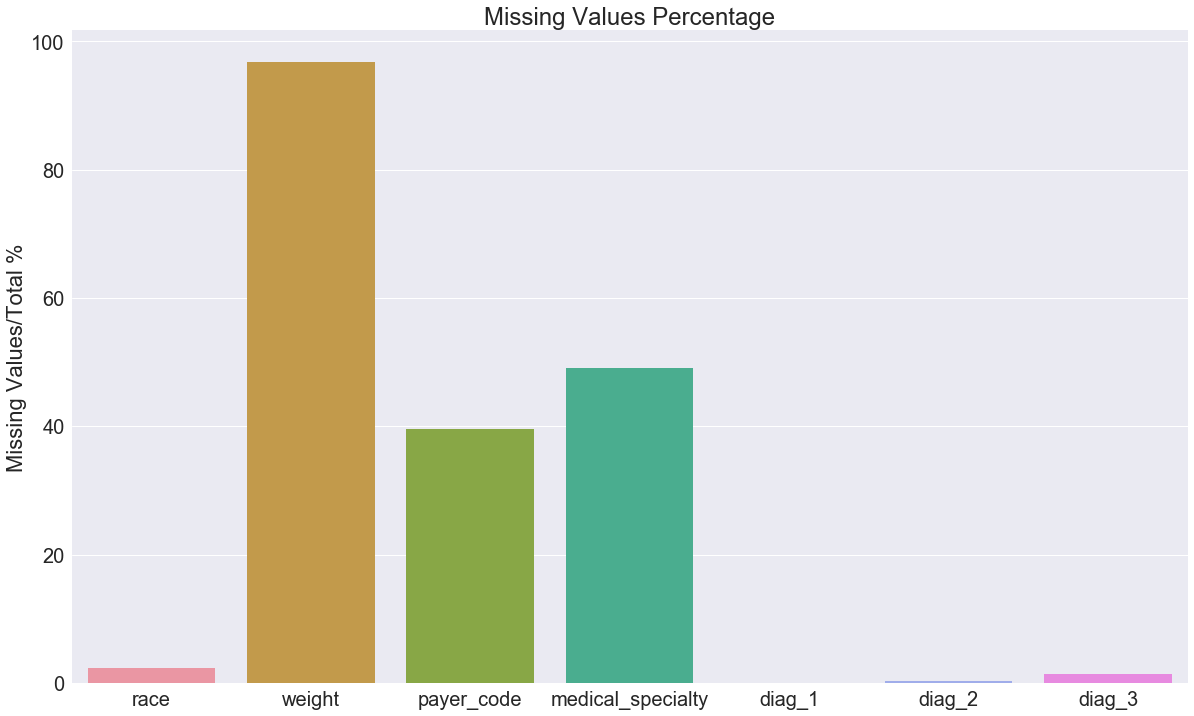

In [8]:
# visualize how many values are missing in percentage for each column
plt.figure(figsize=(20, 12))
plt_missing = plot_bar_char(missing_vals_columns, missing_vals_rate, 
                            'Missing Values Percentage', 'Missing Values/Total %', 
                            2)
plt_missing.show()

Since column "weight" has 96% of data missing, it got deleted first. 

Next, columns, "payer_code" and "medical_specialty", are deleted as well because they are irrelevant to the diagnosis of diabetes.

For more infomation on the attributes, please refer to  https://www.hindawi.com/journals/bmri/2014/781670/.

In [9]:
df = df.drop(columns=['weight', 'payer_code', 'medical_specialty'], axis=1)

The rows with missing values in race, diag_1, diag_2 and diag_3 columns are removed, too. It is not worth imputing these columns with a decision tree because the amount of missing values are insignificant compared to the size of the entire data set.

In [10]:
df = df.dropna(axis=0)

Next, the 24 features for medications are examined, and their corresponding column indices are from 19 to 39.

These columns only have four possible values, 'Up', 'Down', 'Steady' and 'No'.

In [11]:
medications_df = df.iloc[:, 19:40]

In [12]:
no_count = medications_df[medications_df == 'No'].notnull().sum()/medications_df.shape[0]
up_count = medications_df[medications_df == 'Up'].notnull().sum()/medications_df.shape[0]
down_count = medications_df[medications_df == 'Down'].notnull().sum()/medications_df.shape[0]
steady_count = medications_df[medications_df == 'Steady'].notnull().sum()/medications_df.shape[0]

The percentage of 'No' value in each medicine column is shown below.

In [13]:
display(no_count)

metformin                   0.803729
repaglinide                 0.984468
nateglinide                 0.992953
chlorpropamide              0.999154
glimepiride                 0.949140
acetohexamide               0.999990
glipizide                   0.874721
glyburide                   0.895353
tolbutamide                 0.999776
pioglitazone                0.927611
rosiglitazone               0.937116
acarbose                    0.996951
miglitol                    0.999623
troglitazone                0.999969
tolazamide                  0.999623
examide                     1.000000
citoglipton                 1.000000
insulin                     0.468553
glyburide-metformin         0.993177
glipizide-metformin         0.999867
glimepiride-pioglitazone    0.999990
dtype: float64

As we can see from the list above, except for insulin, all columns contain at least 80% of "no" values.
However, before deciding if these medicine columns should be deleted, we have to look at the data composition of readmiited column first.

In [14]:
readmitted_col = df['readmitted']
no_vals = readmitted_col[readmitted_col == 'NO'].shape[0]/df.shape[0]
greater_than_30 = readmitted_col[readmitted_col == '>30'].shape[0]/df.shape[0]
less_than_30 = readmitted_col[readmitted_col == '<30'].shape[0]/df.shape[0]

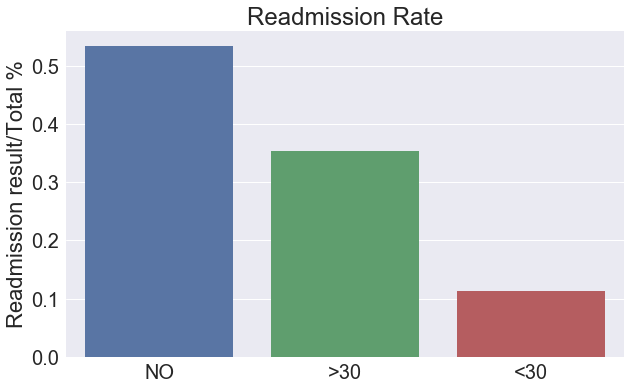

In [15]:
# visualize what the percentage of each value is in readmitted column
plt.figure(figsize=(10, 6))
plt_readmitted = plot_bar_char(["NO", ">30", "<30"],
                               [no_vals, greater_than_30, less_than_30],
                               'Readmission Rate', 'Readmission result/Total %', 2)
plt_readmitted.show()

From the bar chart above, we can see that more than 50% of the patients are not readmitted at all. 

This chart also indicates that, majority of the medications do not give any useful information and will provide no help predicting if a patient will be readmitted.

It is equivalent to random guessing if all the medicines are used, to predict a patient's readmission, except insulin.

As a result, all the columns for medications except insulin are deleted.

In [16]:
df = df.drop(medications_df.columns.values, axis=1)
df['insulin'] = medications_df['insulin']

In [17]:
insulin = pd.DataFrame(medications_df['insulin'])

Before deciding what to do with insulin, a chi-squared test needs to be performed to determine if these is an association between the two columns, insulin and readmitted.

First, apply one-hot encoding to the two columns.

In [18]:
medications_df_temp = insulin.join(df['readmitted'])
medications_df_temp = pd.get_dummies(medications_df_temp)

Next, construct the null and alternative hypotheses:

H0: A change in dosage of insulin is not associated with readmission, and
   
H1: A change in dosage of insulin is associated with readmission

In [19]:
target_columns = ['readmitted_NO', 'readmitted_<30', 'readmitted_>30']

insulin_no_observed = medications_df_temp[medications_df_temp['insulin_No'] == 1][target_columns].sum()
insulin_steady_observed = medications_df_temp[medications_df_temp['insulin_Steady'] == 1][target_columns].sum()
insulin_up_observed = medications_df_temp[medications_df_temp['insulin_Up'] == 1][target_columns].sum()
insulin_down_observed = medications_df_temp[medications_df_temp['insulin_Down'] == 1][target_columns].sum()

row_total = insulin_no_observed + insulin_steady_observed + insulin_up_observed + insulin_down_observed

insulin_no_total = insulin_no_observed.sum()
insulin_steady_total = insulin_steady_observed.sum()
insulin_up_total = insulin_up_observed.sum()
insulin_down_total = insulin_down_observed.sum()
grand_total = insulin_no_total + insulin_steady_total + insulin_up_total + insulin_down_total

# Contingency table for observed data

In [20]:
# construct contingency table for observed data
index = ['readmitted_NO', 'readmitted_<30', 'readmitted_>30', 'total']
columns = ['insulin_No', 'insulin_Steady', 'insulin_Up', 'insulin_Down', 'total']

data_observed = [[insulin_no_observed[0], insulin_steady_observed[0], insulin_up_observed[0], insulin_down_observed[0], row_total[0]], 
        [insulin_no_observed[1], insulin_steady_observed[1], insulin_up_observed[1], insulin_down_observed[1], row_total[1]], 
        [insulin_no_observed[2], insulin_steady_observed[2], insulin_up_observed[2], insulin_down_observed[2], row_total[2]], 
        [insulin_no_total, insulin_steady_total, insulin_up_total, insulin_down_total, grand_total]]

display(pd.DataFrame(data=data_observed, columns=columns, index=index))

,insulin_No,insulin_Steady,insulin_Up,insulin_Down,total
readmitted_NO,25645,15900,5243,5550,52338
readmitted_<30,4658,3313,1434,1661,11066
readmitted_>30,15640,10155,4222,4632,34649
total,45943,29368,10899,11843,98053


# Contingency table for expected table

The expected value in  each cell is equal to : (row total * column total) / (grand total)

In [21]:
insulin_no_expected = round(insulin_no_total*row_total/grand_total, 0)
insulin_steady_expected = round(insulin_steady_total*row_total/grand_total, 0)
insulin_up_expected = round(insulin_up_total*row_total/grand_total, 0)
insulin_down_expected = round(insulin_down_total*row_total/grand_total, 0)

In [22]:
# construct contingency table for expected table
index = ['readmitted_NO', 'readmitted_<30', 'readmitted_>30', 'total']
columns = ['insulin_No', 'insulin_Steady', 'insulin_Up', 'insulin_Down', 'total']

data_expected = [[insulin_no_expected[0], insulin_steady_expected[0], insulin_up_expected[0], insulin_down_expected[0], row_total[0]], 
        [insulin_no_expected[1], insulin_steady_expected[1], insulin_up_expected[1], insulin_down_expected[1], row_total[1]], 
        [insulin_no_expected[2], insulin_steady_expected[2], insulin_up_expected[2], insulin_down_expected[2], row_total[2]], 
        [insulin_no_total, insulin_steady_total, insulin_up_total, insulin_down_total, grand_total]]

display(pd.DataFrame(data=data_expected, columns=columns, index=index))

,insulin_No,insulin_Steady,insulin_Up,insulin_Down,total
readmitted_NO,24523.0,15676.0,5818.0,6321.0,52338
readmitted_<30,5185.0,3314.0,1230.0,1337.0,11066
readmitted_>30,16235.0,10378.0,3851.0,4185.0,34649
total,45943.0,29368.0,10899.0,11843.0,98053


In [23]:
from scipy.stats import chisquare

chi-squared value = the sum of (observed feq - expected feq)^2 / (expected feq).

degrees_freedom = (rows - 1)*(columns-1), 'rows' corresponds to number of categories in one variable, and 'columns' corresponds to number of categories in the second variable.

In [24]:
# perform chi-squared test using scipy package.
f_obs = np.array(data_observed)[:3, 0:4].flatten()
f_exp = np.array(data_expected)[:3, 0:4].flatten()
degrees_freedom  = 6

chisquare(f_obs, f_exp, degrees_freedom)

Power_divergenceResult(statistic=481.4040616090733, pvalue=8.236131498844316e-102)

The chi-squared test statistic is 481.40 with an associated p < 0.001. After comparing the numbers with chi-squared distribution table, the null hypothesis is rejected, and a conclusion is made that the possibility of readmission is associated with a change in dosage of insulin that is prescribed to patients.

Let's continue to examine other features.

In [25]:
df.columns.values

array(['race', 'gender', 'age', 'admission_type_id',
       'discharge_disposition_id', 'admission_source_id',
       'time_in_hospital', 'num_lab_procedures', 'num_procedures',
       'num_medications', 'number_outpatient', 'number_emergency',
       'number_inpatient', 'diag_1', 'diag_2', 'diag_3',
       'number_diagnoses', 'max_glu_serum', 'A1Cresult',
       'metformin-rosiglitazone', 'metformin-pioglitazone', 'change',
       'diabetesMed', 'readmitted', 'insulin'], dtype=object)

Among the remaining columns, only (time_in_hospital, num_lab_procedures, num_procedures, num_medications, number_outpatient, number_emergency, number_inpatient, number_diagnoses) are numerical.

As far as the rest columns containing nominal data, one-hot encoding needs to be applied.

However, before carrying out one-hot encoding, we have to look at diag_1, diag_2, and diag_3 in detail.

The values of these three columns are encoded as the first three digits of ICD9 codes. ICD9 stands for International Classification of Diseases, Ninth Revision. After carefully reading ICD9 codes reference, the codes start with __249__ and __250__ are related to diabetes. Thus, the codes have the prefix of __249__ or __250__ are mapped to 1, and everything else is mapped to 0, where 1 stands for diagnosed with diabetes and 0 otherwise.

ICD9 codes reference: http://icd9.chrisendres.com/index.php?action=contents

In [26]:
from utils.data_processing_utils import map_icd9_codes

In [27]:
df['diag_1'] = map_icd9_codes(df['diag_1'])
df['diag_2'] = map_icd9_codes(df['diag_2'])
df['diag_3'] = map_icd9_codes(df['diag_3'])

Then, let's proceed to perform one-hot encoding.

In [28]:
# carry out one-hot encoding using pandas' get_dummies function
df = pd.get_dummies(df, columns=['race', 'gender', 'age', 'admission_type_id',
       'discharge_disposition_id', 'admission_source_id',
       'diag_1', 'diag_2', 'diag_3', 
        'max_glu_serum', 'A1Cresult',
       'metformin-rosiglitazone', 'metformin-pioglitazone', 'change',
       'diabetesMed', 'insulin'])

# Numeric Data Analysis

Among the 8 numeric features, 'number_outpatient', 'number_emergency', 'number_inpatient' have over 60 % of value 0.

This means these columns contain highly skewed count data. To reduce the effect of skewness, square root transformation is applied to these columns. The reason log transformation is not appropriate here is that the data have the characteristics of Poisson distribution as 0 is the majority value.

The value composition of each column is visualized using a pie chart shown below.

# Number Outpatient

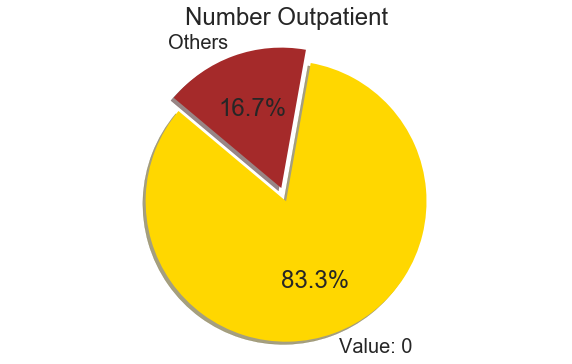

In [29]:
# construct a pie chart
labels = 'Value: 0', 'Others'
data = [df[df['number_outpatient'] == 0].shape[0],
         df[df['number_outpatient'] != 0].shape[0]]
colors = ['gold', 'brown']
explode = (0, 0.1) 

plt.figure(figsize=(10, 6))
plt.title("Number Outpatient")
plot_pie_chart(data, labels, colors, explode).show()

# Number Emergency

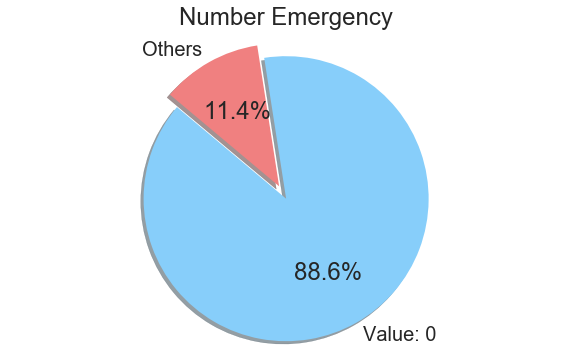

In [30]:
labels = 'Value: 0', 'Others'
data = [df[df['number_emergency'] == 0].shape[0],
         df[df['number_emergency'] != 0].shape[0]]
colors = ['lightskyblue', 'lightcoral']
explode = (0.1, 0) 

plt.figure(figsize=(10, 6))
plt.title("Number Emergency")
plot_pie_chart(data, labels, colors, explode).show()

# Number Inpatient

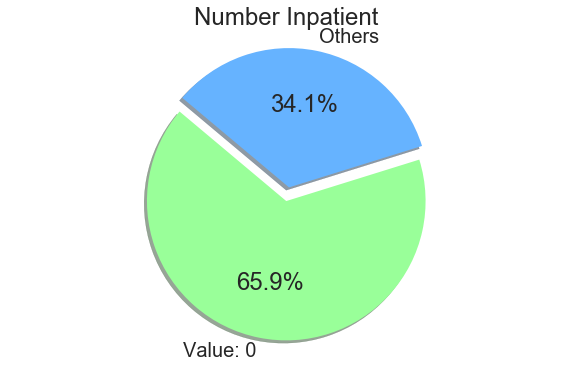

In [31]:
labels = 'Value: 0', 'Others'
data = [df[df['number_inpatient'] == 0].shape[0],
         df[df['number_inpatient'] != 0].shape[0]]
colors = ['#99ff99', '#66b3ff']
explode = (0.1, 0) 

plt.figure(figsize=(10, 6))
plt.title("Number Inpatient")
plot_pie_chart(data, labels, colors, explode).show()

In [32]:
# perform square root transformtion on the columns
df['number_outpatient'] = df['number_outpatient'].apply(lambda x: np.sqrt(x + 0.5))
df['number_emergency'] = df['number_emergency'].apply(lambda x: np.sqrt(x + 0.5))
df['number_inpatient'] = df['number_inpatient'].apply(lambda x: np.sqrt(x + 0.5))

In [33]:
# after the transformation, we rename the columns accordingly
df = df.rename(index=str, columns={'number_outpatient': 'number_outpatient_sqrt',
                                  'number_emergency': 'number_emergency_sqrt',
                                  'number_inpatient': 'number_inpatient_sqrt'})

# Final Feature Analysis: Readmitted column

The readmitted column contains three possible values, which are 'NO', '>30' and '<30'.

'NO' stands for no record of readmission, '<30' if the patient was
readmitted in less than 30 days, and '>30' if the patient was
readmitted in more than 30 days.

Since our objective is to predict a patient's readmission, it is appropriate to combine '>30' and '<30' together as one value.

Therefore, 'NO' is mapped to 0, '>30' and '<30' are mapped to 1.

In [34]:
from utils.data_processing_utils import map_readmitted_col

In [35]:
readmitted_mapper = np.vectorize(map_readmitted_col)
df['readmitted'] = readmitted_mapper(df['readmitted'])

# Post-processed dataset (final)

In [36]:
final_df = df

In [37]:
readmitted_no_percentage = final_df[final_df['readmitted'] == 0].shape[0]/final_df.shape[0]
readmitted_yes_percentage = final_df[final_df['readmitted'] == 1].shape[0]/final_df.shape[0]

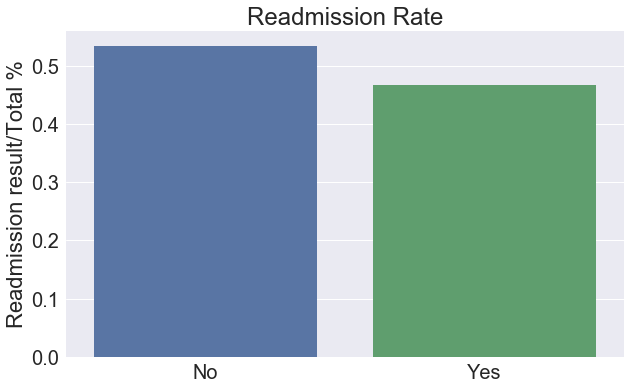

In [38]:
plt.figure(figsize=(10, 6))
plt_readmitted = plot_bar_char(['No', 'Yes'],
                               [readmitted_no_percentage, readmitted_yes_percentage],
                               'Readmission Rate', 'Readmission result/Total %', 2)
plt_readmitted.show()

From the bar chart above, we can tell readmitted column contains more 'NO' label than 'Yes' label. However,since the difference is less than 10%, it is not considered severely imbalanced. As a result, resampling methods such as SMOTE are not used here. 

# Conclusion

After pre-processing the original data, the final data set contains 98053 observations with 103 features.

# Save to a file

Enabled only when it is necessary

In [39]:
#final_df.to_csv(DATA_PATH+'diabetic_data_final.csv', index=False)